 <div style="text-align:center;">
   <span style="color:green; font-size:larger; font-weight:bold;">Exploratory Data Analysis (EDA)</span><br><br>
</div>


<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

Dans cette partie, nous nous intéressons à l'analyse descriptive de la base de données "final_data" obtenue suite au nettoyage des bases de données initiales du fichier "Préparation_données.ipynb"

In [29]:
from importlib import reload
import declarations as d
reload(d)

<module 'declarations' from 'c:\\Users\\user\\Documents\\FRANCE\\python\\Projet-Python\\monmodule\\declarations.py'>

In [30]:
#Importer de la base de données
df = d.pd.read_csv("../final_data.csv")
df.head()

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694
2,1994-01,CAN,10.700000,0.680429,77.871707,1.095258
3,1994-01,AUT,6.609708,0.779464,76.419512,0.384870
4,1994-01,PHL,9.450000,0.329061,67.942000,2.343515


In [31]:
# Telecharger le shapefile
world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))
world=world.rename(columns={'name': 'COUNTRY'})
world.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13288\4038293156.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,COUNTRY,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [32]:
#selectioner certaines colonnes 
world.drop(world.columns.difference(['geometry','COUNTRY','continent']), 1, inplace=True)
#Mettre les noms des colonnes en abbreviation
world['COUNTRY']=d.correct_country_name(world['COUNTRY'])
# fusionner les deux photos
world_df = d.pd.merge(world,df, how='inner', on=['COUNTRY'])
world_df.head(5)
#world.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13288\2543643049.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,continent,COUNTRY,geometry,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-01,10.700000,0.680429,77.871707,1.095258
1,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-02,10.866667,0.680180,77.871707,1.095258
2,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-03,10.366667,0.686270,77.871707,1.095258
3,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-04,10.150000,0.689810,77.871707,1.095258
4,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1995-01,9.550000,0.694571,77.977317,1.034769


In [33]:
world_df.head()

,continent,COUNTRY,geometry,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-01,10.700000,0.680429,77.871707,1.095258
1,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-02,10.866667,0.680180,77.871707,1.095258
2,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-03,10.366667,0.686270,77.871707,1.095258
3,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-04,10.150000,0.689810,77.871707,1.095258
4,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1995-01,9.550000,0.694571,77.977317,1.034769


# <span style="color:green; text-align:center;">II- VISUALISATION DES DONNEES</span>

<Axes: >

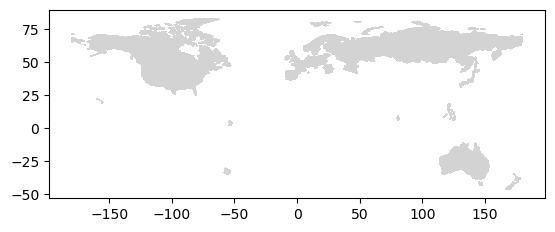

In [34]:
world_df.plot(color='lightgrey')

Deux applications seront créer pour la visualition des données:
- la premiere sera instantanné et à l'echelle mondiale
-la seconde c'est la representation de la serie temporelle par continent.

In [39]:
# Creer un Dash app
app1 = d.dash.Dash(__name__)

# Definir le layout 
app1.layout = d.html.Div([
    #selecteur d'année
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(world_df['YEAR'].unique())],
        value=world_df['YEAR'].min(),  #valeur par defaut de l'année
        multi=False,
    ),
    #selecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    d.dcc.Graph(id='choropleth-map'),
])

# Definir un callback  pour mettre à jour la carte sur l'année selectionnée 
@app1.callback(
    d.Output('choropleth-map', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_map(selected_year, selected_variable):
    subset_gdf = world_df[world_df['YEAR'] == selected_year]
    subset_gdf.index = subset_gdf['COUNTRY']
    fig = d.px.choropleth(
        subset_gdf,
        geojson=subset_gdf.geometry,
        locations=subset_gdf.index,
        color=selected_variable,
        projection="natural earth",
        title=f'{selected_variable} in {selected_year}',
    )
    fig.update_geos(fitbounds="locations", visible=True)
    return fig

# executer l'application
if __name__ == '__main__':
    app1.run_server(debug=True, port=8050)


In [36]:


# Initialiser l'application Dash
app = d.dash.Dash(__name__)

#world_df['YEAR'] = d.pd.to_datetime(world_df['YEAR'])

# Mise en page du tableau de bord
app.layout = d.html.Div([
    d.html.H1("Interactive Dashboard"),
    
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in world_df['YEAR'].unique()],
        value=world_df['YEAR'].min(),
        multi=False,
        style={'width': '50%'}
    ),
    
    d.dcc.Dropdown(
        id='continent-dropdown',
        options=[{'label': continent, 'value': continent} for continent in world_df['continent'].unique()],
        value=world_df['continent'].unique()[0],
        multi=True,
        style={'width': '50%'}
    ),
    
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'Life Expentancy', 'value': 'life_expentancy'},
            {'label': 'Population Growth Rate', 'value': 'pop_growth_rate'},
            {'label': 'GDP Rate', 'value': 'GDP_rate'}
        ],
        value='Unemployment_rate',
        multi=False,
        style={'width': '50%'}
    ),
    
    d.dcc.Graph(id='time-series')
])

# Fonction de mise à jour du graphique en fonction des sélections de l'utilisateur
@app.callback(
    d.Output('time-series', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('continent-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_graph(selected_year, selected_continents, selected_variable):
    #selected_continents = [selected_continents]

    selected_continents = [selected_continents] if not isinstance(selected_continents, list) else selected_continents
    filtered_df = world_df[(world_df['YEAR'] == selected_year)\
                            & (world_df['continent'].isin(selected_continents))]
    



    #filtered_df = world_df[(world_df['YEAR'] == selected_year) & (world_df['continent'].isin(selected_continents))]
    print(filtered_df)  # Ajoutez cette ligne pour imprimer le DataFrame filtré
    

    

     # Utilisez la bibliothèque Plotly pour créer le graphique interactif
    fig, ax = d.plt.subplots(figsize=(10, 6))
    for country, data in filtered_df.groupby('COUNTRY'):
        ax.plot(data['YEAR'], data[selected_variable], marker='o', linestyle='-', label=country)

    ax.set_title(f'{selected_variable} in {selected_year}')
    ax.set_xlabel('Year')
    ax.set_ylabel(selected_variable)
    ax.legend()
    ax.grid(True)

    return fig

    

    
    

# Exécutez l'application
if __name__ == '__main__':
    app.run_server(debug=True)


In [40]:

df=world_df.copy()
app2 = d.dash.Dash(__name__)

# Créez votre graphique initial
fig = d.px.line(df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')

# Créez la mise en page de votre application Dash
app2.layout = d.html.Div([
    # Sélecteur de continents
    d.dcc.Dropdown(
        id='continent-selector',
        options=[
            {'label': continent, 'value': continent}
            for continent in df['continent'].unique()
        ],
        multi=True,
        value=df['continent'].unique()  # Sélectionnez tous les continents par défaut
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='line-chart',
        figure=fig
    )
])

# Définissez la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app2.callback(
    d.Output('line-chart', 'figure'),
    [d.Input('variable-dropdown', 'value'),
     d.Input('continent-selector', 'value')]
)
def update_graph2(selected_variable,selected_continents):
    filtered_df = df[df['continent'].isin(selected_continents)]
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.line(filtered_df, x='YEAR', y=[selected_variable], color='COUNTRY',
                   labels={'YEAR': 'Année', selected_variable: selected_variable})
    return fig


# Exécutez l'application Dash
if __name__ == '__main__':
    app2.run_server(debug=True, port=8051)
